In [1]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.mplot3d import Axes3D

import time
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist
import torch
import itertools

#from scipy.spatial.transform import Rotation as R

from tracking_utils import *

In [66]:
def get_params(locloc):
    locloc = locloc.squeeze()
    short_length = np.sqrt(np.sum((locloc[0,:] - locloc[1,:])**2))
    long_length = np.sqrt(np.sum((locloc[0,:] - locloc[2,:])**2))
    short_vec = (locloc[1,:] - locloc[0,:])
    long_vec = (locloc[2,:] - locloc[0,:])
    angle = np.degrees(np.arccos(short_vec.dot(long_vec)/(np.linalg.norm(short_vec)*np.linalg.norm(long_vec))))
    return short_length, long_length, angle

# camera intrinsics/rig extrinsics 
## (to be modified to pull live data in the future)

In [3]:
intrinsics = load_lut("data/Depth AHaT_lut.bin")
intrinsics_map = np.reshape(intrinsics, (512, 512, -1))

# get pose data (cam2world) for specified session

In [4]:
# time in ms
# transforms in metres
session_name = "13-01-2022-22-25-53" 

depth_trans = np.reshape(np.loadtxt("data/" + session_name + "/depthextrinsics.txt", dtype=str, delimiter="\n"), (-1,5))
depth_trans = np.array([[int(row[0]), np.array("".join(row[1:]).split(",")[:-1]).astype(np.float).reshape(4,4).transpose()] for row in depth_trans])
left_trans = np.reshape(np.loadtxt("data/" + session_name + "/leftextrinsics.txt", dtype=str, delimiter="\n"), (-1,5))
left_trans = np.array([[int(row[0]), np.array("".join(row[1:]).split(",")[:-1]).astype(np.float).reshape(4,4).transpose()] for row in left_trans])
right_trans = np.reshape(np.loadtxt("data/" + session_name + "/rightextrinsics.txt", dtype=str, delimiter="\n"), (-1,5))
right_trans = np.array([[int(row[0]), np.array("".join(row[1:]).split(",")[:-1]).astype(np.float).reshape(4,4).transpose()] for row in right_trans])

# process and visualize tracked data frame by frame

In [91]:
bright_cut = [500, 0.01] # 500
d_threshold = 50 # 35cm

checking = [128,129,130,131,132]
data = []

for idx, depth_t in enumerate(depth_trans[:,0]):

    if idx not in checking:
        continue
    
    depth_map = cv2.imread("data/" + session_name + "/depth/" + str(depth_trans[idx,0]) + "_depth.pgm", -1)
    bright_map = cv2.imread("data/" + session_name + "/depth/" + str(depth_trans[idx,0]) + "_abImage.pgm", -1)

    # prepare contours
    depth_map[depth_map >= 1000] = 1
    depth_map = depth_map / 1000
    far_map = (depth_map > (d_threshold/100)).astype(int)
    recon_far = (bright_map > bright_cut[0]).astype(int) * far_map
    near_map = (far_map * -1) + 1
    bright_edge = cv2.Sobel(bright_map, cv2.CV_32F, 1, 0) > 1000 #2700
    recon_near = bright_edge.astype(np.uint8)
    recon_near = cv2.dilate(recon_near, np.ones((2,2), np.uint8), iterations = 1)
    recon_near = recon_near * near_map                                                      
    border = cv2.dilate((bright_map < 100).astype(np.uint8), np.ones((7,7), np.uint8))
    recon_near = ((recon_near - border) > 0).astype(np.uint8)
    recon_full = recon_far + recon_near
    contours, _ = cv2.findContours(recon_full.astype(np.uint8), 0, method=cv2.CHAIN_APPROX_NONE)    
    cont1 = [c for c in contours if len(c) > 1]

    # process contours
    ret, imloc, locloc = candidate_search(cont1, depth_map, intrinsics_map, recon_full, 1)    
    try:
        if len(imloc) != 1:
            ret = False
    except:
        ret = False
        
    if ret:
        locloc = locloc.squeeze()
    print(str(idx).zfill(4) + ' ' + str(ret).ljust(5), end='\r')
    
    sim_data = []
    print(locloc)
    for offset in np.arange(-10, 10): # mm systematic errors
        current_dist = np.linalg.norm(locloc, axis=1)
        multiplier = (current_dist + offset/1000)/current_dist
        new_locloc = multiplier*locloc
        new_dist = np.linalg.norm(new_locloc, axis=1)
        short_length, long_length, angle = get_params(new_locloc)
        sim_data.append([offset, short_length, long_length, angle])
    sim_data = np.array(sim_data)    
    data.append(sim_data)

data = np.array(data)

[[-0.09252743 -0.09291215  0.3845277 ]
 [-0.07610935 -0.0745495   0.38960695]
 [-0.06520773 -0.11872046  0.39380342]]
[[-0.09204116 -0.09332228  0.3838656 ]
 [-0.07527403 -0.07461107  0.39005563]
 [-0.06510317 -0.12029978  0.39444178]]
[[-0.0910591  -0.09283669  0.38311705]
 [-0.07537206 -0.07512747  0.39137316]
 [-0.06350715 -0.11946867  0.39185482]]
[[-0.09022129 -0.09227651  0.38319138]
 [-0.07431572 -0.07438622  0.39040318]
 [-0.06230006 -0.11833688  0.3910319 ]]
[[-0.08881904 -0.09048389  0.38363963]
 [-0.07264628 -0.07261207  0.38974044]
 [-0.06064149 -0.11707849  0.39080754]]


In [80]:
data.shape

(5, 20, 4)

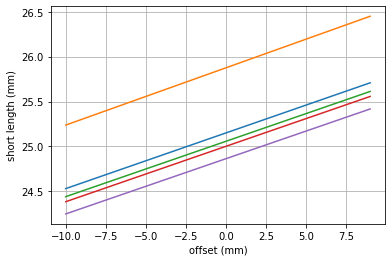

In [85]:
for frame in range(data.shape[0]):
    plt.plot(data[frame, :, 0], 1000*data[frame, :, 1])
plt.grid()
plt.ylabel('short length (mm)')
plt.xlabel('offset (mm)')
plt.show()

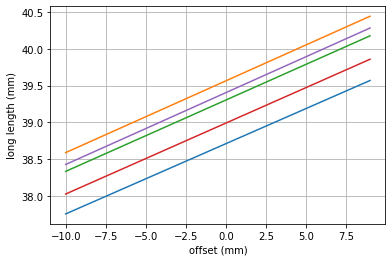

In [86]:
for frame in range(data.shape[0]):
    plt.plot(data[frame, :, 0], 1000*data[frame, :, 2])
plt.grid()
plt.ylabel('long length (mm)')
plt.xlabel('offset (mm)')
plt.show()

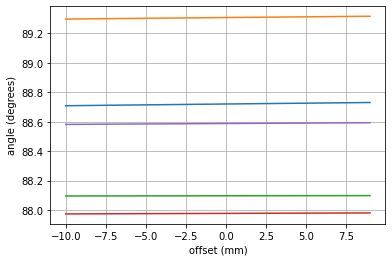

In [90]:
for frame in range(data.shape[0]):
    plt.plot(data[frame, :, 0], data[frame, :, 3])
plt.grid()
plt.ylabel('angle (degrees)')
plt.xlabel('offset (mm)')
plt.show()